# COMS 6998 - Practical Deep Learning System Performance

## Assignment 4
* **Name**: Zach Lawless
* **UNI**: ztl2103

### Problem 1: *Transfer Learning: Shallow Learning vs Fine Tuning, PyTorch* (30 points)

#### Q1

Using [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) as reference.

* a: (4 points)

Using the `vgg-flowers` Visual Domain Decathalon dataset.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '~/data/vgg-flowers'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

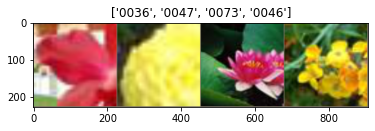

In [3]:
# Funtion to plot image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [4]:
# Show how many classes there are in the training dataset
print(f"There are {len(class_names)} target classes in the training dataset")

There are 102 target classes in the training dataset


In [5]:
# Show the distribution of training images per class
base_dir = '/home/jupyter/data/vgg-flowers/train/'

print("Distribution of training images per class")
for cn in os.listdir(base_dir):
    cn_images = os.listdir(os.path.join(base_dir, cn))
    print(f'Class {cn}: {len(cn_images)} images')

Distribution of training images per class
Class 0028: 10 images
Class 0075: 10 images
Class 0029: 10 images
Class 0009: 10 images
Class 0092: 10 images
Class 0085: 10 images
Class 0061: 10 images
Class 0056: 10 images
Class 0074: 10 images
Class 0050: 10 images
Class 0013: 10 images
Class 0069: 10 images
Class 0040: 10 images
Class 0072: 10 images
Class 0003: 10 images
Class 0017: 10 images
Class 0101: 10 images
Class 0094: 10 images
Class 0026: 10 images
Class 0046: 10 images
Class 0008: 10 images
Class 0071: 10 images
Class 0049: 10 images
Class 0080: 10 images
Class 0067: 10 images
Class 0044: 10 images
Class 0100: 10 images
Class 0102: 10 images
Class 0007: 10 images
Class 0089: 10 images
Class 0015: 10 images
Class 0087: 10 images
Class 0004: 10 images
Class 0077: 10 images
Class 0022: 10 images
Class 0030: 10 images
Class 0090: 10 images
Class 0060: 10 images
Class 0005: 10 images
Class 0025: 10 images
Class 0036: 10 images
Class 0064: 10 images
Class 0053: 10 images
Class 0099: 

In [6]:
# Load pretrained Resnet50 and change final layer
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

* b: (8 points)

In [7]:
# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Set up criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 60 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)

# Send model to device
model_ft = model_ft.to(device)

In [10]:
# Train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 4.6541 Acc: 0.0176
val Loss: 4.5981 Acc: 0.0078

Epoch 1/199
----------
train Loss: 4.5648 Acc: 0.0255
val Loss: 4.4994 Acc: 0.0382

Epoch 2/199
----------
train Loss: 4.4600 Acc: 0.0745
val Loss: 4.3805 Acc: 0.1206

Epoch 3/199
----------
train Loss: 4.3438 Acc: 0.1431
val Loss: 4.2416 Acc: 0.2118

Epoch 4/199
----------
train Loss: 4.2196 Acc: 0.2392
val Loss: 4.0840 Acc: 0.2804

Epoch 5/199
----------
train Loss: 4.0521 Acc: 0.3029
val Loss: 3.8919 Acc: 0.3176

Epoch 6/199
----------
train Loss: 3.8705 Acc: 0.3490
val Loss: 3.6627 Acc: 0.3461

Epoch 7/199
----------
train Loss: 3.6879 Acc: 0.3755
val Loss: 3.4247 Acc: 0.3716

Epoch 8/199
----------
train Loss: 3.4827 Acc: 0.4333
val Loss: 3.2394 Acc: 0.3961

Epoch 9/199
----------
train Loss: 3.2875 Acc: 0.4667
val Loss: 3.0428 Acc: 0.4343

Epoch 10/199
----------
train Loss: 3.1260 Acc: 0.4824
val Loss: 2.8849 Acc: 0.4657

Epoch 11/199
----------
train Loss: 2.9638 Acc: 0.5118
val Loss: 2.7072 Acc

* c: (6 points)

Repeating the exercise above except with uniform learning rate equal to 0.1 and 0.01 and no learning rate decay.

In [12]:
LR_SET = [0.1, 0.01]

for lr in LR_SET:
    print(f'----- Performing experiment with fixed lr={lr} -----\n')
    
    # Load pretrained Resnet50 and change final layer
    model_ft = models.resnet50(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))

    # Set up criterion
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

    # Decay LR by a factor of 0.1 every 1000 epochs (never going to step, setting artifically high for fixing lr)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1000, gamma=0.1)

    # Send model to device
    model_ft = model_ft.to(device)
    
    # Train model
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

----- Performing experiment with fixed lr=0.1 -----

Epoch 0/199
----------
train Loss: 5.0230 Acc: 0.0245
val Loss: 1188.2370 Acc: 0.0098

Epoch 1/199
----------
train Loss: 4.5461 Acc: 0.0275
val Loss: 14788.8348 Acc: 0.0098

Epoch 2/199
----------
train Loss: 4.1641 Acc: 0.0363
val Loss: 59.8500 Acc: 0.0304

Epoch 3/199
----------
train Loss: 3.9120 Acc: 0.0706
val Loss: 4.5217 Acc: 0.0794

Epoch 4/199
----------
train Loss: 3.7342 Acc: 0.0971
val Loss: 3.9473 Acc: 0.0922

Epoch 5/199
----------
train Loss: 3.6327 Acc: 0.1029
val Loss: 4.1090 Acc: 0.1294

Epoch 6/199
----------
train Loss: 3.3773 Acc: 0.1343
val Loss: 3.9952 Acc: 0.1500

Epoch 7/199
----------
train Loss: 3.3204 Acc: 0.1529
val Loss: 3.9736 Acc: 0.1441

Epoch 8/199
----------
train Loss: 3.2241 Acc: 0.1627
val Loss: 3.6558 Acc: 0.1667

Epoch 9/199
----------
train Loss: 3.0926 Acc: 0.2049
val Loss: 3.5001 Acc: 0.1961

Epoch 10/199
----------
train Loss: 2.9732 Acc: 0.2314
val Loss: 3.4149 Acc: 0.2059

Epoch 11/199
-

The results for the three learning rate approaches are below in the table.

| Learning Rate Setting | Best Validation Accuracy |
| ----------------------|--------------------------|
| 0.01 with decay       | 0.790                    |
| 0.1 fixed             | 0.511                    |
| 0.01 fixed            | 0.812                    |

The fixed learning rate of 0.01 for all 200 epochs gave the best validation accuracy for the three experiments.

#### Q2

* a: (8 points)

Treating `ResNet50` as a feature extractor and only training the final layer with various learning rates.

In [15]:
LR_SET = [10**i for i in range(-3, 1)]

for lr in LR_SET:
    print(f'\n----- Performing experiment with fixed lr={lr} -----\n')
    
    model_conv = torchvision.models.resnet50(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, len(class_names))

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 60 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=60, gamma=0.1)
    
    # Train model
    model_conv = train_model(model_conv, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=200)


----- Performing experiment with fixed lr=0.001 -----

Epoch 0/199
----------
train Loss: 4.6677 Acc: 0.0108
val Loss: 4.6238 Acc: 0.0118

Epoch 1/199
----------
train Loss: 4.6135 Acc: 0.0118
val Loss: 4.5593 Acc: 0.0186

Epoch 2/199
----------
train Loss: 4.5441 Acc: 0.0284
val Loss: 4.5050 Acc: 0.0343

Epoch 3/199
----------
train Loss: 4.5042 Acc: 0.0539
val Loss: 4.4517 Acc: 0.0686

Epoch 4/199
----------
train Loss: 4.4565 Acc: 0.0961
val Loss: 4.3994 Acc: 0.1147

Epoch 5/199
----------
train Loss: 4.4064 Acc: 0.1167
val Loss: 4.3486 Acc: 0.1510

Epoch 6/199
----------
train Loss: 4.3431 Acc: 0.1559
val Loss: 4.2957 Acc: 0.1706

Epoch 7/199
----------
train Loss: 4.3102 Acc: 0.1824
val Loss: 4.2480 Acc: 0.2294

Epoch 8/199
----------
train Loss: 4.2588 Acc: 0.2392
val Loss: 4.2025 Acc: 0.2539

Epoch 9/199
----------
train Loss: 4.1990 Acc: 0.2588
val Loss: 4.1507 Acc: 0.2833

Epoch 10/199
----------
train Loss: 4.1591 Acc: 0.2804
val Loss: 4.1033 Acc: 0.3098

Epoch 11/199
------

The best validation accuracy when using `ResNet50` as a feature extractor on `vgg-flowers` for the various learning rates are below.

| Learning Rate Setting | Best Validation Accuracy |
| ----------------------|--------------------------|
| 0.001                 | 0.613                    |
| 0.01                  | 0.627                    |
| 0.1                   | 0.634                    |
| 1                     | 0.625                    |

From above, we can see that 0.1 is the best learning rate for using `ResNet50` as a feature extractor for the `vgg-flowers` VDD dataset.

* b: (4 points)

Given the two transfer learning approaches (Fine Tuning and Feature Extraction) and the various learning rate schemes, using Fine Tuning with a fixed learning rate equal to 0.01 resulted in the best validation accuracy on the holdout dataset. This isn't surprising, as the `ResNet50` model was pretrained on `ImageNet`, not the `vgg-flowers` dataset. Allowing for weight updates on the layers prior to the final Dense layers allows for `ResNet50` to learn features and representations specific to the `vgg-flowers` dataset.

### Problem 2: *Transfer Learning: Shallow Learning vs Fine Tuning, PyTorch* (30 points)